In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [3]:
mat = scipy.io.loadmat('notMNIST_small.mat')
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])

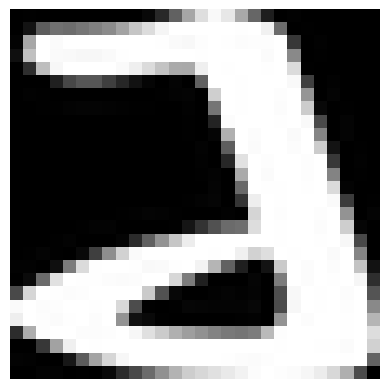

In [4]:
mat['images'].shape

plt.imshow(mat['images'][:, :, 1], cmap='gray')
plt.axis('off')
plt.show()

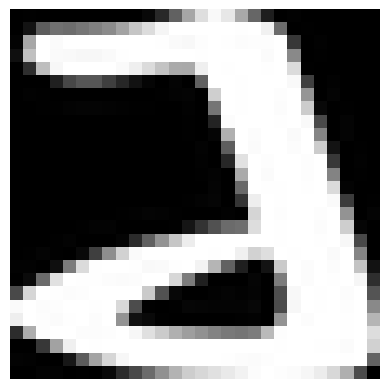

(18724, 28, 28)

In [5]:
new_img = np.random.rand(18724, 28, 28)
for index in range(mat['images'].shape[2]):
    new_img[index] = mat['images'][:,:,index]

plt.imshow(new_img[1, :, :], cmap='gray')
plt.axis('off')
plt.show()

new_img.shape

In [6]:
indices = np.arange(18724)
np.random.shuffle(indices)
labels = np.array(mat['labels'])


shuffled_images = new_img[indices]
shuffled_labels = labels[indices]

In [7]:
x_train_img = np.array(shuffled_images[0:11234, :,:])
x_test_img = np.array(shuffled_images[11235:18724, :,:])
y_train_label = np.array(shuffled_labels[0:11234])
y_test_label =np.array(shuffled_labels[11235:18724])

x_train_img.shape

(11234, 28, 28)

In [8]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy array): Numpy array containing images with shape (18724, 28, 28).
            labels (numpy array): Numpy array containing labels with shape (18724).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # converting to torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [9]:
test_images = x_test_img
test_labels = y_test_label

test_dataset = CustomDataset(test_images, test_labels)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [10]:
from torch.utils.data import DataLoader


images = x_train_img
labels = y_train_label

custom_dataset = CustomDataset(images, labels)


data_loader = DataLoader(dataset=custom_dataset, batch_size=32, shuffle=True)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  #(28/2/2 = 7)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = x2.view(-1, 64 * 7 * 7)
        x4 = F.relu(self.fc1(x3))
        out = self.fc2(x4)
        return x1, x2, x3, x4, out

In [12]:
model = SimpleCNN(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

model = model.to(device)

num_epochs = 20  

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        _, _, _, _, outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')



C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/20, Step 100/352, Loss: 0.43026
Epoch 1/20, Step 200/352, Loss: 0.15402
Epoch 1/20, Step 300/352, Loss: 0.42147
Epoch 2/20, Step 100/352, Loss: 0.07637
Epoch 2/20, Step 200/352, Loss: 0.49367
Epoch 2/20, Step 300/352, Loss: 0.24148
Epoch 3/20, Step 100/352, Loss: 0.17344
Epoch 3/20, Step 200/352, Loss: 0.02049
Epoch 3/20, Step 300/352, Loss: 0.02349
Epoch 4/20, Step 100/352, Loss: 0.04306
Epoch 4/20, Step 200/352, Loss: 0.06635
Epoch 4/20, Step 300/352, Loss: 0.22255
Epoch 5/20, Step 100/352, Loss: 0.00152
Epoch 5/20, Step 200/352, Loss: 0.06448
Epoch 5/20, Step 300/352, Loss: 0.23781
Epoch 6/20, Step 100/352, Loss: 0.04946
Epoch 6/20, Step 200/352, Loss: 0.03685
Epoch 6/20, Step 300/352, Loss: 0.09155
Epoch 7/20, Step 100/352, Loss: 0.00103
Epoch 7/20, Step 200/352, Loss: 0.01225
Epoch 7/20, Step 300/352, Loss: 0.01512
Epoch 8/20, Step 100/352, Loss: 0.00023
Epoch 8/20, Step 200/352, Loss: 0.01279
Epoch 8/20, Step 300/352, Loss: 0.03985
Epoch 9/20, Step 100/352, Loss: 0.01528


In [13]:
def test_model(model, test_loader):
    model = model.to(device)
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)  
            _, _, _, _,outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model(model, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 92.94%


C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/25, Step 100/352, Loss: 0.37716
Epoch 1/25, Step 200/352, Loss: 0.92505
Epoch 1/25, Step 300/352, Loss: 0.17403
Epoch 2/25, Step 100/352, Loss: 0.05264
Epoch 2/25, Step 200/352, Loss: 0.85156
Epoch 2/25, Step 300/352, Loss: 0.19148
Epoch 3/25, Step 100/352, Loss: 0.15986
Epoch 3/25, Step 200/352, Loss: 0.15334
Epoch 3/25, Step 300/352, Loss: 0.08697
Epoch 4/25, Step 100/352, Loss: 0.04722
Epoch 4/25, Step 200/352, Loss: 0.06443
Epoch 4/25, Step 300/352, Loss: 0.23187
Epoch 5/25, Step 100/352, Loss: 0.03696
Epoch 5/25, Step 200/352, Loss: 0.08020
Epoch 5/25, Step 300/352, Loss: 0.29267
Epoch 6/25, Step 100/352, Loss: 0.00169
Epoch 6/25, Step 200/352, Loss: 0.15028
Epoch 6/25, Step 300/352, Loss: 0.21383
Epoch 7/25, Step 100/352, Loss: 0.06991
Epoch 7/25, Step 200/352, Loss: 0.09668
Epoch 7/25, Step 300/352, Loss: 0.00026
Epoch 8/25, Step 100/352, Loss: 0.25966
Epoch 8/25, Step 200/352, Loss: 0.05636
Epoch 8/25, Step 300/352, Loss: 0.00014
Epoch 9/25, Step 100/352, Loss: 0.08138


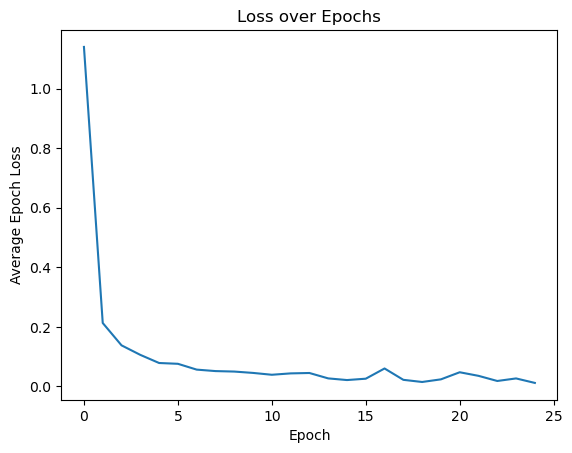

In [14]:
model_2 = SimpleCNN(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001) 

model_2 = model_2.to(device)

num_epochs = 25  
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0  # Reset epoch loss
    num_batches = 0  # To count the number of batches

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        _, _, _, _, outputs = model_2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()


In [15]:
def test_model_2(model_2, test_loader):
    model_2 = model_2.to(device)
    
    model_2.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            images = images.unsqueeze(1)  
            _, _, _, _,outputs = model_2(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model_2(model_2, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 93.00%


In [16]:

class SimpleCNN_x(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN_x, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(3136, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        x3 = x3.view(x3.size(0), -1)  
        x4 = F.relu(self.fc1(x3))
        out = self.fc2(x4)
        return x1, x2, x3, out


C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/25, Step 100/352, Loss: 0.21407
Epoch 1/25, Step 200/352, Loss: 0.04578
Epoch 1/25, Step 300/352, Loss: 0.13193
Epoch 2/25, Step 100/352, Loss: 0.09971
Epoch 2/25, Step 200/352, Loss: 0.14610
Epoch 2/25, Step 300/352, Loss: 0.24881
Epoch 3/25, Step 100/352, Loss: 0.08236
Epoch 3/25, Step 200/352, Loss: 0.09582
Epoch 3/25, Step 300/352, Loss: 0.36316
Epoch 4/25, Step 100/352, Loss: 0.01799
Epoch 4/25, Step 200/352, Loss: 0.22685
Epoch 4/25, Step 300/352, Loss: 0.15828
Epoch 5/25, Step 100/352, Loss: 0.05179
Epoch 5/25, Step 200/352, Loss: 0.01711
Epoch 5/25, Step 300/352, Loss: 0.00983
Epoch 6/25, Step 100/352, Loss: 0.04398
Epoch 6/25, Step 200/352, Loss: 0.01905
Epoch 6/25, Step 300/352, Loss: 0.18265
Epoch 7/25, Step 100/352, Loss: 0.26308
Epoch 7/25, Step 200/352, Loss: 0.01261
Epoch 7/25, Step 300/352, Loss: 0.00404
Epoch 8/25, Step 100/352, Loss: 0.20059
Epoch 8/25, Step 200/352, Loss: 0.00350
Epoch 8/25, Step 300/352, Loss: 0.09858
Epoch 9/25, Step 100/352, Loss: 0.00538


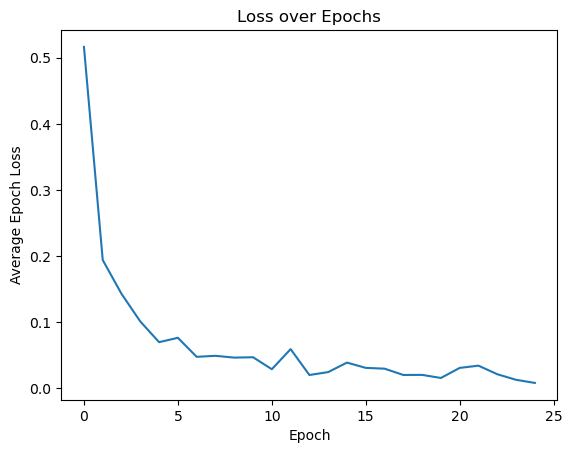

In [17]:
mdlx = SimpleCNN_x(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(mdlx.parameters(), lr=0.001) 

mdlx = mdlx.to(device)

num_epochs = 25  
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0  # Reset epoch loss
    num_batches = 0  # To count the number of batches

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        _, _, _, outputs = mdlx(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()


In [22]:
def test_model_x(mdlx, test_loader):
    mdlx = mdlx.to(device)
    
    mdlx.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            images = images.unsqueeze(1)  
            _, _, _, outputs = mdlx(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model_x(mdlx, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 93.63%


In [18]:

class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)  # updating dimensions
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))  
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))  
        x = x.view(-1, 128 * 7 * 7)  # updating the flattening
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out


C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)
c:\Users\denis\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/50, Step 100/352, Loss: 0.71068
Epoch 1/50, Step 200/352, Loss: 0.90770
Epoch 1/50, Step 300/352, Loss: 0.37948
Epoch 2/50, Step 100/352, Loss: 0.56941
Epoch 2/50, Step 200/352, Loss: 0.16817
Epoch 2/50, Step 300/352, Loss: 0.40649
Epoch 3/50, Step 100/352, Loss: 0.51285
Epoch 3/50, Step 200/352, Loss: 0.27103
Epoch 3/50, Step 300/352, Loss: 0.19188
Epoch 4/50, Step 100/352, Loss: 0.23542
Epoch 4/50, Step 200/352, Loss: 0.20452
Epoch 4/50, Step 300/352, Loss: 0.23232
Epoch 5/50, Step 100/352, Loss: 0.29437
Epoch 5/50, Step 200/352, Loss: 0.18527
Epoch 5/50, Step 300/352, Loss: 0.16811
Epoch 6/50, Step 100/352, Loss: 0.19062
Epoch 6/50, Step 200/352, Loss: 0.46170
Epoch 6/50, Step 300/352, Loss: 0.19019
Epoch 7/50, Step 100/352, Loss: 0.29782
Epoch 7/50, Step 200/352, Loss: 0.07723
Epoch 7/50, Step 300/352, Loss: 0.12337
Epoch 8/50, Step 100/352, Loss: 0.03217
Epoch 8/50, Step 200/352, Loss: 0.20147
Epoch 8/50, Step 300/352, Loss: 0.26545
Epoch 9/50, Step 100/352, Loss: 0.09655


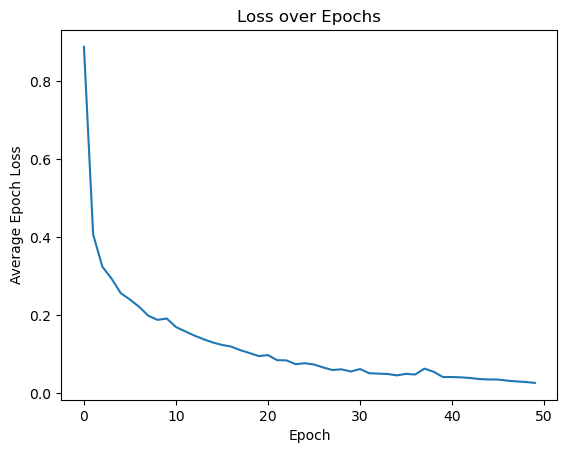

In [19]:
model_x = SimpleCNN_2(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model_x.parameters(), lr=0.001, momentum=0.1)

model_x = model_x.to(device)

num_epochs = 50
epoch_losses  = []

for epoch in range(num_epochs):
    epoch_loss = 0  # Reset epoch loss
    num_batches = 0  # To count the number of batches

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        outputs = model_x(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')
    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)
            
plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()

In [20]:
def test_model_x(model_x, test_loader):
    model_x = model_x.to(device)
    
    model_x.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            images = images.unsqueeze(1)  
            outputs = model_x(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model_x(model_x, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_7352\2518736349.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 93.99%
